**CNN-LSTM model for Human Activity Recognition**


Experiements on [Pamap2](https://archive.ics.uci.edu/ml/datasets/pamap2+physical+activity+monitoring) dataset using different combinations of (with/without) x (channel, temporal and/or spatial attention). 

Baseline CNN-LSTM architecture used is proposed in [Deep Convolutional and LSTM Recurrent Neural Networks for Multimodal Wearable Activity Recognition](https://www.mdpi.com/1424-8220/16/1/115/htm).  

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install pyyaml h5py  # Required to save models in HDF5 format
!pip install -q tensorflow-addons
!pip install keras
!pip install pyts


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# https://github.com/Debarshi-Bhattacharya/Ensem_HAR/blob/9d7769f34258185c56feb7c34f6059e07469030f/Implementation_on_PAMAP2/datapreprocessing.ipynb

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math
import h5py
from sklearn.preprocessing import MinMaxScaler

'''
0: 'transient', 1: 'lying', 2: 'sitting', 3: 'standing', 4: 'walking', 5: 'running', 6: 'cycling', 7: 'Nordic_walking', 9: 'watching_TV', 
10: 'computer_work', 11: 'car driving', 12: 'ascending_stairs', 13: 'descending_stairs', 16: 'vacuum_cleaning', 17: 'ironing', 
18: 'folding_laundry', 19: 'house_cleaning', 20: 'playing_soccer', 24: 'rope_jumping'
'''

def read_files():
    list_of_files = ['Protocol/subject101.dat',
                     'Protocol/subject102.dat',
                     'Protocol/subject103.dat',
                     'Protocol/subject104.dat',
                     'Protocol/subject105.dat',
                     'Protocol/subject106.dat',
                     'Protocol/subject107.dat',
                     'Protocol/subject108.dat',
                     'Protocol/subject109.dat']
    
    subjectID = [1,2,3,4,5,6,7,8,9]
    
    # there are 54 columns in the data files
    colNames = ["timestamp", "activityID","heartrate"] # 1, 2, 3
    IMUhand = ['handTemperature', 
               'handAcc16_1', 'handAcc16_2', 'handAcc16_3', 
               'handAcc6_1', 'handAcc6_2', 'handAcc6_3', 
               'handGyro1', 'handGyro2', 'handGyro3', 
               'handMagne1', 'handMagne2', 'handMagne3',
               'handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4'] # 4-20
    IMUchest = ['chestTemperature', 
               'chestAcc16_1', 'chestAcc16_2', 'chestAcc16_3', 
               'chestAcc6_1', 'chestAcc6_2', 'chestAcc6_3', 
               'chestGyro1', 'chestGyro2', 'chestGyro3', 
               'chestMagne1', 'chestMagne2', 'chestMagne3',
               'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4'] # 21-37
    IMUankle = ['ankleTemperature', 
               'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3', 
               'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3', 
               'ankleGyro1', 'ankleGyro2', 'ankleGyro3', 
               'ankleMagne1', 'ankleMagne2', 'ankleMagne3',
               'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4'] # 38-54
    
    columns = colNames + IMUhand + IMUchest + IMUankle
    
    dataCollection = pd.DataFrame()

    for file in list_of_files:
        print(file)
        procData = pd.read_table(file, header=None, sep='\s+')
        procData.columns = columns
        dataCollection = dataCollection.append(procData, ignore_index=True) 
        
    dataCollection.reset_index(drop=True, inplace=True)
    
    return dataCollection

data = read_files()
data.head()

Protocol/subject101.dat
Protocol/subject102.dat
Protocol/subject103.dat
Protocol/subject104.dat
Protocol/subject105.dat
Protocol/subject106.dat
Protocol/subject107.dat
Protocol/subject108.dat
Protocol/subject109.dat


,timestamp,activityID,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,...,ankleGyro1,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4
0,8.38,0,104.0,30.0,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,0.008300,0.009250,-0.017580,-61.1888,-38.9599,-58.1438,1.0,0.0,0.0,0.0
1,8.39,0,NaN,30.0,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,-0.006577,-0.004638,0.000368,-59.8479,-38.8919,-58.5253,1.0,0.0,0.0,0.0
2,8.40,0,NaN,30.0,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.003014,0.000148,0.022495,-60.7361,-39.4138,-58.3999,1.0,0.0,0.0,0.0
3,8.41,0,NaN,30.0,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,0.003175,-0.020301,0.011275,-60.4091,-38.7635,-58.3956,1.0,0.0,0.0,0.0
4,8.42,0,NaN,30.0,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,0.012698,-0.014303,-0.002823,-61.5199,-39.3879,-58.2694,1.0,0.0,0.0,0.0


In [6]:
def dataCleaning(dataCollection):
    dataCollection = dataCollection.drop(['timestamp', 'handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4',
                                         'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4',
                                         'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4'],
                                         axis = 1)  # removal of orientation columns as they are not needed
    dataCollection = dataCollection.drop(dataCollection[dataCollection.activityID == 0].index) # removal of any row of activity 0 as it is transient activity which it is not used
    dataCollection = dataCollection.apply(pd.to_numeric, errors = 'coerce') # removal of non numeric data in cells
    dataCollection = dataCollection.drop(['heartrate'], axis = 1)
    dataCollection = dataCollection.dropna()

    dataCollection = dataCollection.drop(['handTemperature', 'chestTemperature', 'ankleTemperature'],
                                         axis = 1)  # removal of temperature columns as they are not needed - sumeyye
    print("data cleaned!")
    return dataCollection

cleaned_data = dataCleaning(data)
print(cleaned_data['activityID'].value_counts())
cleaned_data.head()

data cleaned!
17    237902
4     229709
1     192290
3     188984
2     184645
7     184444
16    174976
6     163302
12    117094
13    104865
5      95641
24     47579
Name: activityID, dtype: int64


,activityID,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,handGyro1,handGyro2,handGyro3,...,ankleAcc16_3,ankleAcc6_1,ankleAcc6_2,ankleAcc6_3,ankleGyro1,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3
2928,1,2.21530,8.27915,5.58753,2.24689,8.55387,5.77143,-0.004750,0.037579,-0.011145,...,0.095156,9.63162,-1.76757,0.265761,0.002908,-0.027714,0.001752,-61.1081,-36.8636,-58.3696
2929,1,2.29196,7.67288,5.74467,2.27373,8.14592,5.78739,-0.171710,0.025479,-0.009538,...,-0.020804,9.58649,-1.75247,0.250816,0.020882,0.000945,0.006007,-60.8916,-36.3197,-58.3656
2930,1,2.29090,7.14240,5.82342,2.26966,7.66268,5.78846,-0.238241,0.011214,0.000831,...,-0.059173,9.60196,-1.73721,0.356632,-0.035392,-0.052422,-0.004882,-60.3407,-35.7842,-58.6119
2931,1,2.21800,7.14365,5.89930,2.22177,7.25535,5.88000,-0.192912,0.019053,0.013374,...,0.094385,9.58674,-1.78264,0.311453,-0.032514,-0.018844,0.026950,-60.7646,-37.1028,-57.8799
2932,1,2.30106,7.25857,6.09259,2.20720,7.24042,5.95555,-0.069961,-0.018328,0.004582,...,0.095775,9.64677,-1.75240,0.295902,0.001351,-0.048878,-0.006328,-60.2040,-37.1225,-57.8847


In [7]:
def reset_label(dataCollection): 
    # Convert original labels {1, 2, 3, 4, 5, 6, 7, 12, 13, 16, 17, 24} to new labels. 
    mapping = {24:0,1:1,2:2,3:3,4:4,5:5,6:6,7:7,12:8,13:9,16:10,17:11} # old activity Id to new activity Id 
    for i in [24,12,13,16,17]:
        dataCollection.loc[dataCollection.activityID == i, 'activityID'] = mapping[i]

    return dataCollection
data_reset = reset_label(cleaned_data)  
data_reset.head()

,activityID,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,handGyro1,handGyro2,handGyro3,...,ankleAcc16_3,ankleAcc6_1,ankleAcc6_2,ankleAcc6_3,ankleGyro1,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3
2928,1,2.21530,8.27915,5.58753,2.24689,8.55387,5.77143,-0.004750,0.037579,-0.011145,...,0.095156,9.63162,-1.76757,0.265761,0.002908,-0.027714,0.001752,-61.1081,-36.8636,-58.3696
2929,1,2.29196,7.67288,5.74467,2.27373,8.14592,5.78739,-0.171710,0.025479,-0.009538,...,-0.020804,9.58649,-1.75247,0.250816,0.020882,0.000945,0.006007,-60.8916,-36.3197,-58.3656
2930,1,2.29090,7.14240,5.82342,2.26966,7.66268,5.78846,-0.238241,0.011214,0.000831,...,-0.059173,9.60196,-1.73721,0.356632,-0.035392,-0.052422,-0.004882,-60.3407,-35.7842,-58.6119
2931,1,2.21800,7.14365,5.89930,2.22177,7.25535,5.88000,-0.192912,0.019053,0.013374,...,0.094385,9.58674,-1.78264,0.311453,-0.032514,-0.018844,0.026950,-60.7646,-37.1028,-57.8799
2932,1,2.30106,7.25857,6.09259,2.20720,7.24042,5.95555,-0.069961,-0.018328,0.004582,...,0.095775,9.64677,-1.75240,0.295902,0.001351,-0.048878,-0.006328,-60.2040,-37.1225,-57.8847


In [8]:
X=data_reset.drop(['activityID'],axis=1)
y=data_reset['activityID']
X.head()

,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,handGyro1,handGyro2,handGyro3,handMagne1,...,ankleAcc16_3,ankleAcc6_1,ankleAcc6_2,ankleAcc6_3,ankleGyro1,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3
2928,2.21530,8.27915,5.58753,2.24689,8.55387,5.77143,-0.004750,0.037579,-0.011145,8.93200,...,0.095156,9.63162,-1.76757,0.265761,0.002908,-0.027714,0.001752,-61.1081,-36.8636,-58.3696
2929,2.29196,7.67288,5.74467,2.27373,8.14592,5.78739,-0.171710,0.025479,-0.009538,9.58300,...,-0.020804,9.58649,-1.75247,0.250816,0.020882,0.000945,0.006007,-60.8916,-36.3197,-58.3656
2930,2.29090,7.14240,5.82342,2.26966,7.66268,5.78846,-0.238241,0.011214,0.000831,9.05516,...,-0.059173,9.60196,-1.73721,0.356632,-0.035392,-0.052422,-0.004882,-60.3407,-35.7842,-58.6119
2931,2.21800,7.14365,5.89930,2.22177,7.25535,5.88000,-0.192912,0.019053,0.013374,9.92698,...,0.094385,9.58674,-1.78264,0.311453,-0.032514,-0.018844,0.026950,-60.7646,-37.1028,-57.8799
2932,2.30106,7.25857,6.09259,2.20720,7.24042,5.95555,-0.069961,-0.018328,0.004582,9.15626,...,0.095775,9.64677,-1.75240,0.295902,0.001351,-0.048878,-0.006328,-60.2040,-37.1225,-57.8847


In [10]:
def scale(df): # minmax scale
    features=df.columns[0:X.shape[1]]
    scaler = MinMaxScaler(feature_range=(-1,1))
    df[features]=scaler.fit_transform(df[features])
    return df

X_scaled = scale(X)
X_scaled.head()

,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,handGyro1,handGyro2,handGyro3,handMagne1,...,ankleAcc16_3,ankleAcc6_1,ankleAcc6_2,ankleAcc6_3,ankleGyro1,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3
2928,0.417516,-0.133999,-0.174116,0.113009,0.134484,0.093285,0.031349,-0.125912,-0.003356,-0.065176,...,0.000769,0.143942,-0.029670,0.015502,0.186908,0.141361,-0.082024,-0.154691,-0.129512,-0.644683
2929,0.418253,-0.138662,-0.172903,0.113480,0.127909,0.093543,0.025227,-0.126503,-0.003244,-0.059784,...,0.000039,0.143204,-0.029426,0.015259,0.187797,0.143168,-0.081745,-0.153053,-0.124827,-0.644651
2930,0.418242,-0.142743,-0.172296,0.113408,0.120122,0.093560,0.022788,-0.127200,-0.002519,-0.064156,...,-0.000202,0.143457,-0.029180,0.016977,0.185013,0.139803,-0.082458,-0.148886,-0.120213,-0.646624
2931,0.417542,-0.142733,-0.171710,0.112568,0.113557,0.095039,0.024450,-0.126817,-0.001641,-0.056935,...,0.000764,0.143208,-0.029913,0.016243,0.185156,0.141920,-0.080374,-0.152093,-0.131573,-0.640759
2932,0.418340,-0.141849,-0.170219,0.112313,0.113316,0.096259,0.028958,-0.128644,-0.002256,-0.063319,...,0.000773,0.144190,-0.029425,0.015991,0.186831,0.140026,-0.082553,-0.147852,-0.131743,-0.640798


In [13]:
INITIAL_SAMPLING_RATE = 100 #Hz
WINDOW_SIZE = 1 #second

SLIDING_WINDOW_LENGTH = INITIAL_SAMPLING_RATE*WINDOW_SIZE

def segment_signal(data_x, data_y, window_size): # data is numpy array
    X, y = [], []
    start, end = 0, 0
    while start + window_size - 1 < data_x.shape[0]:
        end = start + window_size - 1
        # if the frame contains the same activity and from the same object
        X.append(data_x[start:(end+1),:])
        y.append(data_y[start])
        start += window_size #without overlap (for 50% overlap use window_size//2)
    return [np.asarray(X), np.asarray(y)]

data = segment_signal(X_scaled.to_numpy(), y.to_numpy(), SLIDING_WINDOW_LENGTH)
data_x, data_y = data[0], data[1]
print(data_x.shape)
print(data_y.shape)

(19214, 100, 36)
(19214,)


In [14]:
# Data is reshaped since the input of the network is a 4 dimension tensor
data_x = data_x.reshape((-1, data_x.shape[1], data_x.shape[2], 1))
print(data_x.shape)

(19214, 100, 36, 1)


In [16]:
# https://stackoverflow.com/questions/53731141/cifar10-randomize-train-and-test-set
def shuffle_train_data(X_train, Y_train): 
    perm = np.random.permutation(len(Y_train)) 
    Xtr_shuf = X_train[perm] 
    Ytr_shuf = Y_train[perm] 
    return Xtr_shuf, Ytr_shuf 
X_shuffled, y_shuffled = shuffle_train_data(data_x, data_y) 
print(X_shuffled.shape) 
print(y_shuffled.shape)

(19214, 100, 36, 1)
(19214,)


In [17]:
#https://stackoverflow.com/questions/53731141/cifar10-randomize-train-and-test-set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.33, random_state=1234)
print("X_train " + str(X_train.shape) + "\ny_train " + str(y_train.shape) + "\nX_test  " + str(X_test.shape)+ "\ny_test  " + str(y_test.shape)) 

X_train (12873, 100, 36, 1)
y_train (12873,)
X_test  (6341, 100, 36, 1)
y_test  (6341,)


In [25]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Flatten, Input, Conv2D, Permute, Reshape
from keras import optimizers, losses, metrics, initializers

from collections import Counter
NUM_CLASSES = len(Counter(y_shuffled).keys())

BATCH_SIZE = 50 
NUM_FILTERS = 4 # Number filters convolutional layers
FILTER_SIZE = 6 # Size filters convolutional layers
NUM_UNITS_LSTM = 8 # Number of unit in the long short-term recurrent layers
NB_SENSOR_CHANNELS = data_x.shape[2]
SLIDING_WINDOW_LENGTH = data_x.shape[1]
print ("NUM_CLASSES: " + str(NUM_CLASSES))

NUM_CLASSES: 12


In [27]:
model = keras.Sequential()
model._name="Experiement1_CNNLSTM_without_Attention"
model.add(Input(shape=(SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS, 1)))

#intializing weights
initializer = initializers.Orthogonal()

# CNN 
model.add(Conv2D(NUM_FILTERS, kernel_size=(FILTER_SIZE, 1), activation="relu", kernel_initializer = initializer))
model.add(Conv2D(NUM_FILTERS*2, kernel_size=(FILTER_SIZE, 1), activation="relu",kernel_initializer = initializer))
model.add(Permute((2,1,3)))
model.add(Reshape((int(model.layers[2].output_shape[1]), int(model.layers[2].output_shape[2]) * int(model.layers[2].output_shape[3]))))

# LSTM 
model.add(LSTM(NUM_UNITS_LSTM, dropout=0.5,return_sequences=True,kernel_initializer = initializer))
model.add(Flatten())

model.add(Dense(NUM_CLASSES))

model.summary()

model.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=30,validation_split=0.2)
model.evaluate(X_test, y_test)

Model: "Experiement1_CNNLSTM_without_Attention"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 95, 36, 4)         28        
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 36, 8)         200       
                                                                 
 permute_1 (Permute)         (None, 36, 90, 8)         0         
                                                                 
 reshape_1 (Reshape)         (None, 36, 720)           0         
                                                                 
 lstm_1 (LSTM)               (None, 36, 8)             23328     
                                                                 
 flatten_1 (Flatten)         (None, 288)               0         
                                                                 
 dense_1 (Dense)            

[0.24792474508285522, 0.9318719506263733]

In [28]:
# https://github.com/EscVM/EscVM_YT/blob/master/Notebooks/0%20-%20TF2.X%20Tutorials/tf_2_visual_attention.ipynb

from keras.layers import Layer, GlobalAveragePooling2D, GlobalMaxPooling2D, Add, Activation, Multiply

class ChannelAttention(Layer):
      def __init__(self, filters, ratio):
        super(ChannelAttention, self).__init__()
        self.filters = filters
        self.ratio = ratio

        def build(self, input_shape):
            self.shared_layer_one = Dense(self.filters//self.ratio,
                             activation='relu', kernel_initializer='he_normal', 
                              use_bias=True, 
                              bias_initializer='zeros')
            self.shared_layer_two = Dense(self.filters,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

        def call(self, inputs):
            # AvgPool
            avg_pool = GlobalAveragePooling2D()(inputs)
            

            avg_pool = self.shared_layer_one(avg_pool)
            avg_pool = self.shared_layer_two(avg_pool)

            # MaxPool
            max_pool = GlobalMaxPooling2D()(inputs)
            max_pool = Reshape((1,1,filters))(max_pool)

            max_pool = shared_layer_one(max_pool)
            max_pool = shared_layer_two(max_pool)


            attention = Add()([avg_pool,max_pool])
            attention = Activation('sigmoid')(attention)
            
            return Multiply()([inputs, attention])

In [29]:
# https://github.com/EscVM/EscVM_YT/blob/master/Notebooks/0%20-%20TF2.X%20Tutorials/tf_2_visual_attention.ipynb

from keras.layers import Lambda, Concatenate, multiply
from keras import backend

class SpatialAttention(Layer):
      def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size
        
        def build(self, input_shape):
            self.conv2d = Conv2D(filters = 1,
                    kernel_size=self.kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)

        def call(self, inputs):
            
            # AvgPool
            avg_pool = Lambda(lambda x: backend.mean(x, axis=3, keepdims=True))(inputs)
            
            # MaxPool
            max_pool = Lambda(lambda x: backend.max(x, axis=3, keepdims=True))(inputs)

            attention = Concatenate(axis=3)([avg_pool, max_pool])

            attention = self.conv2d(attention)


            return Multiply([inputs, attention]) 

In [ ]:
# https://github.com/ManzhuYu/Code-SpatioTemporalAttention-LSTM-main/blob/main/modelbase.py # temporal module and spatial module

In [30]:
model_2 = keras.Sequential()
model_2._name="Experiement2_CNNLSTM_with_spatial_Attention"
model_2.add(Input(shape=(SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS, 1)))

#intializing weights
initializer = initializers.Orthogonal()

# CNN 
model_2.add(Conv2D(NUM_FILTERS, kernel_size=(FILTER_SIZE, 1), activation="relu", kernel_initializer = initializer))
SpatialAttention(3),
model_2.add(Conv2D(NUM_FILTERS*2, kernel_size=(FILTER_SIZE, 1), activation="relu",kernel_initializer = initializer))
model_2.add(Permute((2,1,3)))
model_2.add(Reshape((int(model_2.layers[2].output_shape[1]), int(model_2.layers[2].output_shape[2]) * int(model_2.layers[2].output_shape[3]))))

# LSTM 
model_2.add(LSTM(NUM_UNITS_LSTM, dropout=0.5,return_sequences=True,kernel_initializer = initializer))
model_2.add(Flatten())

model_2.add(Dense(NUM_CLASSES))

model_2.summary()

model_2.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

model_2.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=30,validation_split=0.2)
model_2.evaluate(X_test, y_test)

Model: "Experiement2_CNNLSTM_with_spatial_Attention"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 95, 36, 4)         28        
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 36, 8)         200       
                                                                 
 permute_2 (Permute)         (None, 36, 90, 8)         0         
                                                                 
 reshape_2 (Reshape)         (None, 36, 720)           0         
                                                                 
 lstm_2 (LSTM)               (None, 36, 8)             23328     
                                                                 
 flatten_2 (Flatten)         (None, 288)               0         
                                                                 
 dense_2 (Dense)       

[0.23123647272586823, 0.9321873784065247]

In [31]:
model_3 = keras.Sequential()
model_3._name="Experiement3_CNNLSTM_with_channel_Attention"
model_3.add(Input(shape=(SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS, 1)))

#intializing weights
initializer = initializers.Orthogonal()

# CNN 
model_3.add(Conv2D(NUM_FILTERS, kernel_size=(FILTER_SIZE, 1), activation="relu", kernel_initializer = initializer))
ChannelAttention(8, 4),
model_3.add(Conv2D(NUM_FILTERS*2, kernel_size=(FILTER_SIZE, 1), activation="relu",kernel_initializer = initializer))
model_3.add(Permute((2,1,3)))
model_3.add(Reshape((int(model_3.layers[2].output_shape[1]), int(model_3.layers[2].output_shape[2]) * int(model_3.layers[2].output_shape[3]))))

# LSTM 
model_3.add(LSTM(NUM_UNITS_LSTM, dropout=0.5,return_sequences=True,kernel_initializer = initializer))
model_3.add(Flatten())

model_3.add(Dense(NUM_CLASSES))

model_3.summary()

model_3.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

model_3.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=30,validation_split=0.2)
model_3.evaluate(X_test, y_test)

Model: "Experiement3_CNNLSTM_with_channel_Attention"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 95, 36, 4)         28        
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 36, 8)         200       
                                                                 
 permute_3 (Permute)         (None, 36, 90, 8)         0         
                                                                 
 reshape_3 (Reshape)         (None, 36, 720)           0         
                                                                 
 lstm_3 (LSTM)               (None, 36, 8)             23328     
                                                                 
 flatten_3 (Flatten)         (None, 288)               0         
                                                                 
 dense_3 (Dense)       

[0.2295159101486206, 0.9380223751068115]

In [32]:
model_4 = keras.Sequential()
model_4._name="Experiement4_CNNLSTM_with_temporal_Attention"
model_4.add(Input(shape=(SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS, 1)))

#intializing weights
initializer = initializers.Orthogonal()

# CNN 
model_4.add(Conv2D(NUM_FILTERS, kernel_size=(FILTER_SIZE, 1), activation="relu", kernel_initializer = initializer))
model_4.add(Conv2D(NUM_FILTERS*2, kernel_size=(FILTER_SIZE, 1), activation="relu",kernel_initializer = initializer))
model_4.add(Permute((2,1,3)))
model_4.add(Reshape((int(model_4.layers[2].output_shape[1]), int(model_4.layers[2].output_shape[2]) * int(model_4.layers[2].output_shape[3]))))

# LSTM 
model_4.add(LSTM(NUM_UNITS_LSTM, dropout=0.5,return_sequences=True,kernel_initializer = initializer))
model_4.add(Dense(NUM_UNITS_LSTM*SLIDING_WINDOW_LENGTH, input_shape=(SLIDING_WINDOW_LENGTH,), activation=None)) # temporal module
model_4.add(Flatten())

model_4.add(Dense(NUM_CLASSES))

model_4.summary()

model_4.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

model_4.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=30,validation_split=0.2)
model_4.evaluate(X_test, y_test)

Model: "Experiement4_CNNLSTM_with_temporal_Attention"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 95, 36, 4)         28        
                                                                 
 conv2d_9 (Conv2D)           (None, 90, 36, 8)         200       
                                                                 
 permute_4 (Permute)         (None, 36, 90, 8)         0         
                                                                 
 reshape_4 (Reshape)         (None, 36, 720)           0         
                                                                 
 lstm_4 (LSTM)               (None, 36, 8)             23328     
                                                                 
 dense_4 (Dense)             (None, 36, 800)           7200      
                                                                 
 flatten_4 (Flatten)  

[0.2256810963153839, 0.9408610463142395]

In [33]:
model_5 = keras.Sequential()
model_5._name="Experiement5_CNNLSTM_with_spatial_channel_Attention"
model_5.add(Input(shape=(SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS, 1)))

#intializing weights
initializer = initializers.Orthogonal()

# CNN 
model_5.add(Conv2D(NUM_FILTERS, kernel_size=(FILTER_SIZE, 1), activation="relu", kernel_initializer = initializer))
ChannelAttention(8, 4)
SpatialAttention(3)
model_5.add(Conv2D(NUM_FILTERS*2, kernel_size=(FILTER_SIZE, 1), activation="relu",kernel_initializer = initializer))
model_5.add(Permute((2,1,3)))
model_5.add(Reshape((int(model_5.layers[2].output_shape[1]), int(model_5.layers[2].output_shape[2]) * int(model_5.layers[2].output_shape[3]))))

# LSTM 
model_5.add(LSTM(NUM_UNITS_LSTM, dropout=0.5,return_sequences=True,kernel_initializer = initializer))
model_5.add(Flatten())

model_5.add(Dense(NUM_CLASSES))

model_5.summary()

model_5.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

model_5.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=30,validation_split=0.2)
model_5.evaluate(X_test, y_test)

Model: "Experiement5_CNNLSTM_with_spatial_channel_Attention"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 95, 36, 4)         28        
                                                                 
 conv2d_11 (Conv2D)          (None, 90, 36, 8)         200       
                                                                 
 permute_5 (Permute)         (None, 36, 90, 8)         0         
                                                                 
 reshape_5 (Reshape)         (None, 36, 720)           0         
                                                                 
 lstm_5 (LSTM)               (None, 36, 8)             23328     
                                                                 
 flatten_5 (Flatten)         (None, 288)               0         
                                                                 
 dense_6 (Dense

[0.21680068969726562, 0.9366030693054199]

In [34]:
model_6 = keras.Sequential()
model_6._name="Experiement6_CNNLSTM_with_spatial_temporal_Attention"
model_6.add(Input(shape=(SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS, 1)))

#intializing weights
initializer = initializers.Orthogonal()

# CNN 
model_6.add(Conv2D(NUM_FILTERS, kernel_size=(FILTER_SIZE, 1), activation="relu", kernel_initializer = initializer))
SpatialAttention(3)
model_6.add(Conv2D(NUM_FILTERS*2, kernel_size=(FILTER_SIZE, 1), activation="relu",kernel_initializer = initializer))
model_6.add(Permute((2,1,3)))
model_6.add(Reshape((int(model_6.layers[2].output_shape[1]), int(model_6.layers[2].output_shape[2]) * int(model_6.layers[2].output_shape[3]))))

# LSTM 
model_6.add(LSTM(NUM_UNITS_LSTM, dropout=0.5,return_sequences=True,kernel_initializer = initializer))
model_6.add(Dense(NUM_UNITS_LSTM*SLIDING_WINDOW_LENGTH, input_shape=(SLIDING_WINDOW_LENGTH,), activation=None)) # temporal module
model_6.add(Flatten())

model_6.add(Dense(NUM_CLASSES))

model_6.summary()

model_6.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

model_6.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=30,validation_split=0.2)
model_6.evaluate(X_test, y_test)

Model: "Experiement6_CNNLSTM_with_spatial_temporal_Attention"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 95, 36, 4)         28        
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 36, 8)         200       
                                                                 
 permute_6 (Permute)         (None, 36, 90, 8)         0         
                                                                 
 reshape_6 (Reshape)         (None, 36, 720)           0         
                                                                 
 lstm_6 (LSTM)               (None, 36, 8)             23328     
                                                                 
 dense_7 (Dense)             (None, 36, 800)           7200      
                                                                 
 flatten_6 (Fl

[0.20855584740638733, 0.9466961026191711]

In [35]:
model_7 = keras.Sequential()
model_7._name="Experiement7_CNNLSTM_with_channel_temporal_Attention"
model_7.add(Input(shape=(SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS, 1)))

#intializing weights
initializer = initializers.Orthogonal()

# CNN 
model_7.add(Conv2D(NUM_FILTERS, kernel_size=(FILTER_SIZE, 1), activation="relu", kernel_initializer = initializer))
ChannelAttention(8, 4)
model_7.add(Conv2D(NUM_FILTERS*2, kernel_size=(FILTER_SIZE, 1), activation="relu",kernel_initializer = initializer))
model_7.add(Permute((2,1,3)))
model_7.add(Reshape((int(model_7.layers[2].output_shape[1]), int(model_7.layers[2].output_shape[2]) * int(model_7.layers[2].output_shape[3]))))

# LSTM 
model_7.add(LSTM(NUM_UNITS_LSTM, dropout=0.5,return_sequences=True,kernel_initializer = initializer))
model_7.add(Dense(NUM_UNITS_LSTM*SLIDING_WINDOW_LENGTH, input_shape=(SLIDING_WINDOW_LENGTH,), activation=None)) # temporal module
model_7.add(Flatten())

model_7.add(Dense(NUM_CLASSES))

model_7.summary()

model_7.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

model_7.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=30,validation_split=0.2)
model_7.evaluate(X_test, y_test)

Model: "Experiement7_CNNLSTM_with_channel_temporal_Attention"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 95, 36, 4)         28        
                                                                 
 conv2d_15 (Conv2D)          (None, 90, 36, 8)         200       
                                                                 
 permute_7 (Permute)         (None, 36, 90, 8)         0         
                                                                 
 reshape_7 (Reshape)         (None, 36, 720)           0         
                                                                 
 lstm_7 (LSTM)               (None, 36, 8)             23328     
                                                                 
 dense_9 (Dense)             (None, 36, 800)           7200      
                                                                 
 flatten_7 (Fl

[0.20505858957767487, 0.9466961026191711]

In [37]:
model_8 = keras.Sequential()
model_8._name="Experiement8_CNNLSTM_with_spatial_channel_temporal_Attention"
model_8.add(Input(shape=(SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS, 1)))

#intializing weights
initializer = initializers.Orthogonal()

# CNN 
model_8.add(Conv2D(NUM_FILTERS, kernel_size=(FILTER_SIZE, 1), activation="relu", kernel_initializer = initializer))
ChannelAttention(8, 4)
SpatialAttention(3)
model_8.add(Conv2D(NUM_FILTERS*2, kernel_size=(FILTER_SIZE, 1), activation="relu",kernel_initializer = initializer))
model_8.add(Permute((2,1,3)))
model_8.add(Reshape((int(model_8.layers[2].output_shape[1]), int(model_8.layers[2].output_shape[2]) * int(model_8.layers[2].output_shape[3]))))

# LSTM 
model_8.add(LSTM(NUM_UNITS_LSTM, dropout=0.5,return_sequences=True,kernel_initializer = initializer))
model_8.add(Dense(NUM_UNITS_LSTM*SLIDING_WINDOW_LENGTH, input_shape=(SLIDING_WINDOW_LENGTH,), activation=None)) # temporal module
model_8.add(Flatten())

model_8.add(Dense(NUM_CLASSES))

model_8.summary()

model_8.compile(
    optimizer=keras.optimizers.RMSprop(),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

model_8.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=50,validation_split=0.2)
model_8.evaluate(X_test, y_test)

Model: "Experiement8_CNNLSTM_with_spatial_channel_temporal_Attention"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 95, 36, 4)         28        
                                                                 
 conv2d_19 (Conv2D)          (None, 90, 36, 8)         200       
                                                                 
 permute_9 (Permute)         (None, 36, 90, 8)         0         
                                                                 
 reshape_9 (Reshape)         (None, 36, 720)           0         
                                                                 
 lstm_9 (LSTM)               (None, 36, 8)             23328     
                                                                 
 dense_13 (Dense)            (None, 36, 800)           7200      
                                                                 
 flatt

[0.2304803729057312, 0.9418072700500488]

Summary:

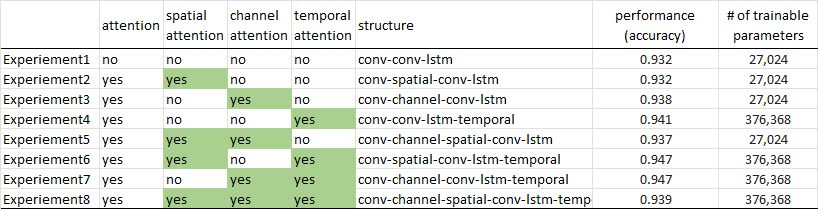

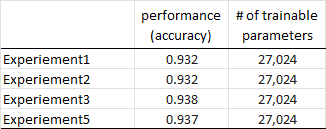

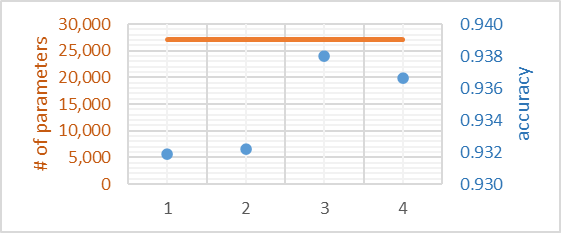